In [1]:
!pip install netCDF4
!pip install requests beautifulsoup4
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.9 MB/s eta 0:00:00


Download data

In [ ]:
import os
import requests
import numpy as np
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor


YEARS = range(2020, 2025)

SAMPLE_DAYS_PER_MONTH = 31

BASE_URL = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l1b/seis-l1b-sgps"



def create_year_folders():

    for year in YEARS:
        os.makedirs(f"goes16_data/{year}", exist_ok=True)

def get_monthly_files(year, month):

    url = f"{BASE_URL}/{year}/{month:02d}/"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        return [link['href'] for link in soup.find_all("a")
               if link['href'].endswith('.nc') and 'ops_seis-l1b-sgps' in link['href']]
    except Exception as e:
        print(f"Error fetching {year}-{month:02d}: {str(e)}")
        return []

def download_file(year, month, day_file):

    day = day_file[20:22]
    url = f"{BASE_URL}/{year}/{month:02d}/{day_file}"
    local_path = f"goes16_data/{year}/{day_file}"

    if not os.path.exists(local_path):
        try:
            with requests.get(url, stream=True, timeout=15) as response:
                response.raise_for_status()
                with open(local_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            print(f"Downloaded {year}/{month:02d}/{day_file}")
            return True
        except Exception as e:
            print(f"Failed {year}/{month:02d}/{day_file}: {str(e)}")
            return False
    return True

def process_year_month(year, month):

    files = get_monthly_files(year, month)
    if not files:
        return 0


    sample_indices = np.linspace(0, len(files)-1, dtype=int)
    sampled_files = [files[i] for i in sample_indices]


    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(lambda f: download_file(year, month, f), sampled_files))

    return sum(results)

def main():
    create_year_folders()
    total_downloaded = 0

    for year in YEARS:
        for month in range(1, 13):
            downloaded = process_year_month(year, month)
            total_downloaded += downloaded

    print(f"\nDownload complete {total_downloaded} files saved in year folders.")

if __name__ == "__main__":
    main()

Find cumulative flux

In [ ]:
from netCDF4 import Dataset
import numpy as np
from pathlib import Path
from collections import defaultdict


BASE_DIR = '/content/goes16_data/'
YEARS = range(2020, 2025)


total_fluence = {}

first_file = None
for yr in YEARS:
    d = Path(BASE_DIR) / str(yr)
    if d.exists():
        files = sorted(d.glob('*.nc'))
        if files:
            first_file = files[0]
            break
if first_file is None:
    raise RuntimeError("No netCDF files")

with Dataset(first_file, 'r') as nc:
    for t in range(3):
        var = nc[f'T{t+1}_DifferentialProtonFluxes']
        _, _, nbin = var.shape
        total_fluence[f'T{t+1}'] = np.zeros((2, nbin), dtype=np.float64)


file_paths = []
for year in YEARS:
    d = Path(BASE_DIR) / str(year)
    if d.exists():
        file_paths.extend(sorted(d.glob('*.nc')))


def accumulate_file(fp):
  try:
    with Dataset(fp, 'r') as nc:

        for t in range(3):
            tel = f'T{t+1}'
            flux = nc[f'{tel}_DifferentialProtonFluxes'][:]  # shape (86400,2,nbin)

            daily = np.ma.filled(flux, 0.0).sum(axis=0)  # shape (2,nbin)
            total_fluence[tel] += daily
  except Exception as e:
          print(f"Error processing file {fp}: {str(e)}")

for fp in file_paths:
    accumulate_file(fp)

print(total_fluence)

Format

In [ ]:
import numpy as np

for_all_files_binsum = [
    [[], [], []],  #For -X
    [[], [], []]   #For +X
]

telescope_mapping = {
    'T1': 0,
    'T2': 1,
    'T3': 2
}


for telescope, data in total_fluence.items():
    tel_index = telescope_mapping[telescope]
    for direction in range(2):
        for_all_files_binsum[direction][tel_index] = data[direction].tolist()


print(for_all_files_binsum)


Skip if you ran the Finding cumulative flux

In [35]:
for_all_files_binsum = [[[6923950.129382193, 2399822.3035821915, 1370381.8431704268, 461830.7198556885, 214892.41605386138, 19879.96289345622], [2296.0594076365232, 530.0979111287743], [144.405482403934, 232.24412351101637, 90.46763387601823, 44.40717894304544, 27.040173853747547]], [[10354037.124269962, 3456736.156858146, 1267076.3191419393, 419728.33999849856, 72491.36225815117, 14285.513829886913], [1890.3972719777375, 368.96591744199395], [154.15224638115615, 248.65924776904285, 89.04301674291492, 61.55935924034566, 37.08134780917317]]]

Sum for x and +x directions

In [36]:
# Sum x and x+
summed_flux = [
    [for_all_files_binsum[0][0][k] + for_all_files_binsum[1][0][k] for k in range(6)],  # T1
    [for_all_files_binsum[0][1][k] + for_all_files_binsum[1][1][k] for k in range(2)],  # T2
    [for_all_files_binsum[0][2][k] + for_all_files_binsum[1][2][k] for k in range(5)],  # T3
]

Conver to Fluence

In [37]:
import numpy as np
scaling_factor = 4 * np.pi * 1000
energy_bins = [
    [(1.0, 1.9), (1.9, 2.3), (2.3, 3.4), (3.4, 6.5), (6.5, 12.0), (12.0, 25.0)],
    [(25.0, 40.0), (40.0, 80.0)],
    [(83.0, 99.0), (99.0, 118.0), (118.0, 150.0), (150.0, 275.0), (275.0, 500.0)]
]

summed_fluence = []
for flux_group, bin_group in zip(summed_flux, energy_bins):
    group_fluence = []
    for flux, (low, high) in zip(flux_group, bin_group):
        width = high - low
        fluence = flux * scaling_factor * width
        group_fluence.append(fluence)
    summed_fluence.append(group_fluence)

Create input_spectrum

In [38]:
gamma = 3
spectrum = []
energies = [[(1.0, 1.9), (1.9, 2.3), (2.3, 3.4), (3.4, 6.5), (6.5, 12.0), (12.0, 25.0)],
            [(25.0, 40.0), (40.0, 80.0)],
            [(83.0, 99.0), (99.0, 118.0), (118.0, 150.0), (150.0, 275.0), (275.0, 500.0)]]

# (T1, T2, T3)
for i in range(len(summed_fluence)):
    for j in range(len(summed_fluence[i])):
        e_low, e_high = energies[i][j]
        total_fluence = summed_fluence[i][j]

        # 10 logarithmic sub bins per energy band
        sub_bins = np.logspace(np.log10(e_low), np.log10(e_high), num=11)
        mid_points = np.sqrt(sub_bins[:-1] * sub_bins[1:])
        bin_widths = sub_bins[1:] - sub_bins[:-1]

        #  power-law weights
        weights = mid_points ** -gamma
        weights /= weights.sum()  # Normalize within band


        for mp, w, bw in zip(mid_points, weights, bin_widths):
            spectrum.append((mp, total_fluence * w, bw))

# to PDF
energies_list, counts, widths = zip(*spectrum)
total_counts = sum(counts)
pdf_values = [c/(total_counts * w) for c, w in zip(counts, widths)]

with open('input_spectrum.txt', 'w') as f:
    f.write("Energy (MeV)\tPDF\n")
    for e, pdf in sorted(zip(energies_list, pdf_values), key=lambda x: x[0]):
        f.write(f"{e:.6f}\t{pdf:.6e}\n")

# verif
integral = sum(pdf * w for pdf, w in zip(pdf_values, widths))
print(f"PDF integral: {integral:.6f} (should be ≈1.0)")
print(f"Energy range: {min(energies_list):.1f}-{max(energies_list):.1f} MeV")
print(f"Number of bins: {len(energies_list)}")


PDF integral: 1.000000 (should be ≈1.0)
Energy range: 1.0-485.3 MeV
Number of bins: 130


In [39]:
SOLID_ANGLES = [4*np.pi,4*np.pi,4*np.pi]#[1.84, 1.84, 6.28]  # T1, T2, T3

Calculate Total fluence

In [40]:
total_fluence = 0.0

for t in range(3):  # (T1, T2, T3)
    for k in range(len(energy_bins[t])):  # energy bins
        E_low, E_high = energy_bins[t][k]
        bin_width_keV = (E_high - E_low) * 1000  # MeV to keV

        # Fluence = Flux * Solid Angle * Energy Bin Width
        fluence_bin = summed_flux[t][k] * SOLID_ANGLES[t] * bin_width_keV
        total_fluence += fluence_bin

print(f"Total omnidirectional fluence (5 years): {total_fluence:.2e} protons/cm²")

Total omnidirectional fluence (5 years): 3.23e+11 protons/cm²


In [55]:
copper_L = 0.0001  # mm
copper_W = 0.01   # mm

world_L = 0.06  # mm
world_W = 0.06  # mm

copper_area = (copper_L * 0.1) * (copper_W * 0.1)  # cm2
world_area = (world_L * 0.1) * (world_W * 0.1)     # cm2

Protons to simulate

In [56]:
protons_to_simulate = total_fluence * world_area*8 #40 years

print(f"\nProtons to simulate: {protons_to_simulate}")
print(f"Expected copper hits: {total_fluence * copper_area*8}")


Protons to simulate: 93002931.81884167
Expected copper hits: 25834.147727456017


After grasshopper simulation put the output .dat file as input

N_atoms: 849103326.723948
E_dep_eV: 6462767.368254076
DPA: 0.00016913966546566094
delta_rho: 6.934726284092098e-10
NRT Model Results (1e-07×1e-05×1e-08 m Cu)
DPA (NRT): 1.691e-04
Resistance change: 4.127813264340519%


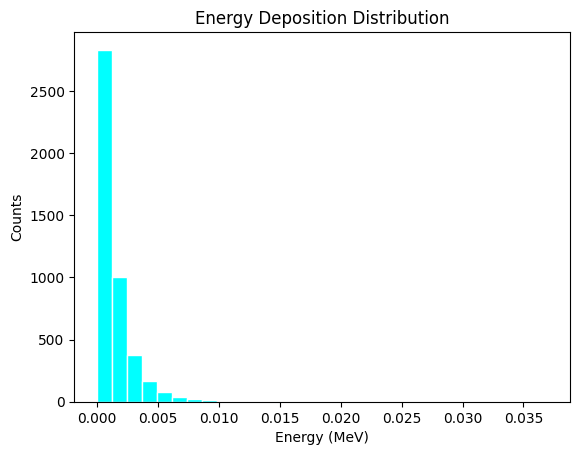

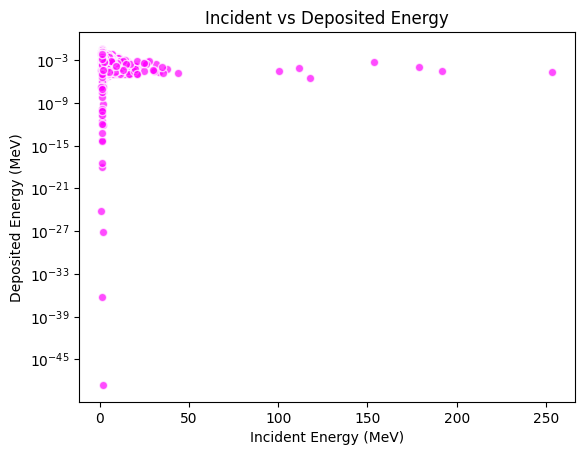

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def apply_white_theme():
    plt.rcParams.update({
        'figure.facecolor': 'white', 'axes.facecolor': 'white',
        'axes.edgecolor': 'black', 'axes.labelcolor': 'black',
        'xtick.color': 'black', 'ytick.color': 'black',
        'text.color': 'black', 'axes.titlecolor': 'black',
        'grid.color': 'gray', 'grid.alpha': 0.3,
    })
def apply_dark_blue_theme():
    plt.rcParams.update({
        'figure.facecolor': '#0d1b2a',
        'axes.facecolor': '#0d1b2a',
        'axes.edgecolor': 'white',
        'axes.labelcolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white',
        'text.color': 'white',
        'axes.titlecolor': 'white',
        'grid.color': 'gray',
        'grid.alpha': 0.3,
    })

df = pd.read_csv(
    '/content/out_40_w006_100_10m_10nm',
    sep='\t',
    names=[
        'E_beam', 'E_incident', 'E_deposited', 'x_incident', 'y_incident',
        'z_incident', 'theta', 'Time', 'EventID', 'TrackID', 'ParticleID',
        'ParticleName', 'CreatorProcessName', 'IsEdepositedTotalEntry',
        'IsSurfaceHitTrack', 'detector#'
    ],
    skiprows=1
)


df_cu = df[(df['detector#'] == 0) & (df['E_deposited'] > 0) & (df['E_incident'] > 0) & (df['ParticleName'] == 'proton')]


rho_0 = 1.68e-8  # Cu resistivity ohm·m
eta = 0.8         # NRT efficiency factor
E_d = 18.0        # Displacement threshold 18[eV]
alpha = 4.1e-6    # drho/DPA

# in meter
L = 100e-9
W = 10e-6
T = 10e-9
A = W * T  # cross section
V = L * A   #Vol


rho_Cu = 8960         #Density kg/m3
M_Cu = 0.063546       #Molar mass kg/mol
N_atoms = (rho_Cu * V / M_Cu) * 6.022e23  #Atoms in volume
print(f"N_atoms: {N_atoms}")

E_dep_eV = (df_cu['E_deposited']).sum() * 1e6  #MeV to eV
print(f"E_dep_eV: {E_dep_eV}")
DPA = (0.8 * E_dep_eV) / (2 * E_d * N_atoms)  #NRT formula
print(f"DPA: {DPA}")
delta_rho = alpha * DPA  #resistivity change
print(f"delta_rho: {delta_rho}")


R0 = rho_0 * L / A
R_new = (rho_0 + delta_rho) * L / A
delta_R_pct = ((R_new - R0)/R0) * 100


print(f"NRT Model Results ({L}×{W}×{T} m Cu)")
print(f"DPA (NRT): {DPA:.3e}")
print(f"Resistance change: {delta_R_pct}%")


# apply_dark_blue_theme()
apply_white_theme()
plt.hist(df_cu['E_deposited'], bins=30, color='cyan', edgecolor='white')
plt.title('Energy Deposition Distribution')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.show()
plt.scatter(df_cu['E_beam'], df_cu['E_deposited'],
            color='magenta', alpha=0.7, edgecolor='white')
plt.yscale('log')
plt.title('Incident vs Deposited Energy')
plt.xlabel('Incident Energy (MeV)')
plt.ylabel('Deposited Energy (MeV)')
plt.show()